<img style="float: left; margin: 30px 15px 15px 15px;" src="https://pngimage.net/wp-content/uploads/2018/06/logo-iteso-png-5.png" width="300" height="500" /> 
    
    
### <font color='navy'> Simulación de procesos financieros. 

**Nombres:** Dayana Navarro Valencia y Juan Pablo Ruiz Magaña

**Fecha:** 7 de mayo del 2021

**Expediente** : if721470
**Profesor:** Oscar David Jaramillo Zuluaga.

## Link de Github: https://github.com/DayanaNavarro/Tarea-11

# Tarea 11: Clase 24

# Tarea
Realizar la valuación de las opciones barrera para las acciones de Microsoft, siguiendo los siguientes lineamientos:
1. Realizar la valuación para el tipo de opción barrera 'CALL'- down-and-out, usando la suposición de rendimientos normales y usando el método del histograma. Para ambas valuaciones, comparar los resultados de la evaluación obtenida con los resultados obtenidos por la valuación Europea. Como se realizó en clase.
2. Repetir el inciso anterior pero en esta ocasión para el caso de 'PUT'- Up-and-out.

**Nota:** Analice los datos descargados y según el método ya sea `down-and-out` o `Up-and-out` defina un strike price usando la volatility smile vista en la clase de opciones europeas y basado en el spot price y el strike defina una barrera adecuada.

Se habilitará un enlace en canvas para subir un cuaderno de python, con la solución.

**Criterio de revisión.**

> Se te calificará de acuerdo a los resultados finales que reportes, basados en tu análisis.

# RESPUESTA DAYANA

In [2]:
#importar los paquetes que se van a usar
import pandas as pd
import pandas_datareader.data as web
import numpy as np
from sklearn.neighbors import KernelDensity
import datetime
from datetime import datetime, timedelta
import scipy.stats as st
import scipy as sp
import scipy.optimize as optimize
import scipy.cluster.hierarchy as hac
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


# ACTIVO MC´DONALS

In [3]:
# Función para descargar precios de cierre ajustados:
def get_adj_closes(tickers, start_date=None, end_date=None):
    # Fecha inicio por defecto (start_date='2010-01-01') y fecha fin por defecto (end_date=today)
    # Descargamos DataFrame con todos los datos
    closes = web.DataReader(name=tickers, data_source='yahoo', start=start_date, end=end_date)
    # Solo necesitamos los precios ajustados en el cierre
    closes = closes['Adj Close']
    # Se ordenan los índices de manera ascendente
    closes.sort_index(inplace=True)
    return closes

####### Calculation of log-returns
def calc_daily_ret(closes):
    return np.log(closes/closes.shift(1)).dropna()

In [4]:
closes = get_adj_closes(['MCD'], '2017-01-01')
closes_mc = closes.loc[:,'MCD']
closes_mc.head()

Date
2017-01-03    107.688629
2017-01-04    107.562599
2017-01-05    107.760643
2017-01-06    108.714912
2017-01-09    108.417847
Name: MCD, dtype: float64

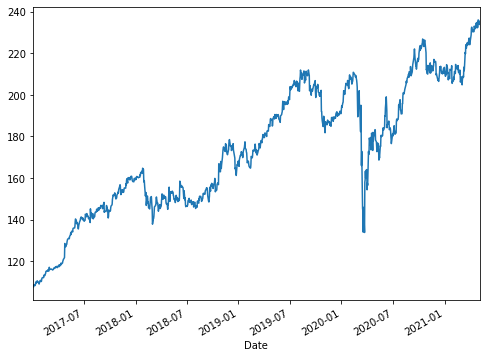

In [5]:
closes_mc.plot(figsize=(8,6));

In [6]:
closes_mc[-1]

235.0399932861328

## Calculamos rendimientos

In [7]:
ret_mc = calc_daily_ret(closes_mc)

## Descargamos datos de opciones para poder valuarlos

In [8]:
pd.set_option('display.max_rows', 10)

mc = web.YahooOptions('MCD')
mc_opt = mc.get_all_data().reset_index()
mc_opt.set_index('Expiry').sort_index()#.head(1000)

,Strike,Type,Symbol,Last,Bid,Ask,Chg,PctChg,Vol,Open_Int,IV,Root,IsNonstandard,Underlying,Underlying_Price,Quote_Time,Last_Trade_Date,JSON
Expiry,,,,,,,,,,,,,,,,,,
2021-05-07,217.5,call,MCD210507C00217500,17.80,16.25,18.90,0.00,0.000000,5.0,8.0,0.834963,MCD,False,MCD,235.04,2021-05-05 20:00:02,2021-04-30 17:18:23,"{'contractSymbol': 'MCD210507C00217500', 'stri..."
2021-05-07,230.0,call,MCD210507C00230000,4.58,4.85,5.60,0.11,2.460853,50.0,445.0,0.265144,MCD,False,MCD,235.04,2021-05-05 20:00:02,2021-05-05 17:16:51,"{'contractSymbol': 'MCD210507C00230000', 'stri..."
2021-05-07,230.0,put,MCD210507P00230000,0.23,0.21,0.27,-0.25,-52.083332,278.0,921.0,0.207527,MCD,False,MCD,235.04,2021-05-05 20:00:02,2021-05-05 19:34:19,"{'contractSymbol': 'MCD210507P00230000', 'stri..."
2021-05-07,232.5,call,MCD210507C00232500,3.09,2.79,3.10,0.91,41.743110,476.0,555.0,0.177498,MCD,False,MCD,235.04,2021-05-05 20:00:02,2021-05-05 19:22:49,"{'contractSymbol': 'MCD210507C00232500', 'stri..."
2021-05-07,232.5,put,MCD210507P00232500,0.55,0.45,0.54,-0.43,-43.877552,280.0,394.0,0.174325,MCD,False,MCD,235.04,2021-05-05 20:00:02,2021-05-05 19:27:40,"{'contractSymbol': 'MCD210507P00232500', 'stri..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-20,145.0,call,MCD230120C00145000,80.80,86.15,89.40,0.00,0.000000,1.0,4.0,0.000010,MCD,False,MCD,235.04,2021-05-05 20:00:02,2021-03-17 18:46:10,"{'contractSymbol': 'MCD230120C00145000', 'stri..."
2023-01-20,145.0,put,MCD230120P00145000,3.73,2.92,4.15,0.00,0.000000,4.0,133.0,0.308265,MCD,False,MCD,235.04,2021-05-05 20:00:02,2021-04-29 14:29:48,"{'contractSymbol': 'MCD230120P00145000', 'stri..."
2023-01-20,150.0,call,MCD230120C00150000,85.18,82.50,87.50,0.00,0.000000,1.0,41.0,0.251625,MCD,False,MCD,235.04,2021-05-05 20:00:02,2021-04-30 17:19:31,"{'contractSymbol': 'MCD230120C00150000', 'stri..."


## Volatility smile 

In [44]:
fecha = '2021-05-15'
call_f1 = mc_opt.loc[(mc_opt.Expiry== fecha1) & (mc_opt.Type=='call')]


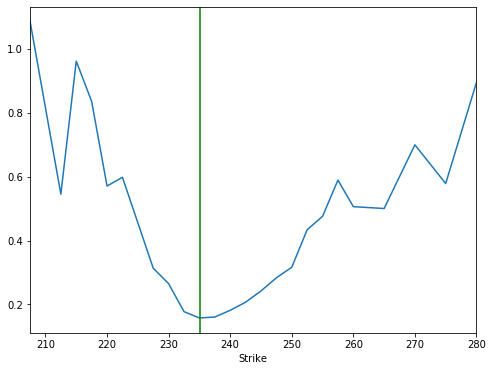

In [38]:
# Para los call de la fecha 1
ax = call_f1.set_index('Strike').loc[:, 'IV'].plot(figsize=(8,6))
ax.axvline(call_f1.Underlying_Price.iloc[0], color='g');

In [46]:
opt_deseada = mc_opt.loc[(mc_opt.Type=='call') & (mc_opt.Strike==230) & (mc_opt.Expiry=='2021-05-07')]
opt_deseada

,Strike,Expiry,Type,Symbol,Last,Bid,Ask,Chg,PctChg,Vol,Open_Int,IV,Root,IsNonstandard,Underlying,Underlying_Price,Quote_Time,Last_Trade_Date,JSON
369,230.0,2021-05-07,call,MCD210507C00230000,4.58,4.85,5.6,0.11,2.460853,50.0,445.0,0.265144,MCD,False,MCD,235.04,2021-05-05 20:00:02,2021-05-05 17:16:51,"{'contractSymbol': 'MCD210507C00230000', 'stri..."


In [47]:
opt_valuar = opt_deseada.loc[list(opt_deseada.index)[0]]
opt_valuar

Strike                                                            230
Expiry                                            2021-05-07 00:00:00
Type                                                             call
Symbol                                             MCD210507C00230000
Last                                                             4.58
                                          ...                        
Underlying                                                        MCD
Underlying_Price                                               235.04
Quote_Time                                        2021-05-05 20:00:02
Last_Trade_Date                                   2021-05-05 17:16:51
JSON                {'contractSymbol': 'MCD210507C00230000', 'stri...
Name: 369, Length: 19, dtype: object

# Simulación de precios

### 1.1 Modelo normal de rendimientos

In [48]:
mu = ret_mc.mean()
sigma = ret_mc.std()
r = (0.06/100) / 360
mu, sigma, r

(0.0007154094263900964, 0.015203373533159606, 1.6666666666666665e-06)

In [49]:
from datetime import date

# Datos de la opción y del día de actual
today = pd.Timestamp(date.today())
expiry = opt_valuar.Expiry

# Fechas desde el día de hoy hasta la fecha de cierre del contrato (considerando unicamente los días hábiles)
dates = pd.date_range(start=today, end=expiry, freq='B')

# Cantidad de escenarios a simular para el método de montecarlo
ndays = len(dates)
nscen = 10000

K = opt_valuar.Strike
S0 = closes_mc.iloc[-1]
sim_ret = pd.DataFrame(sigma*np.random.randn(ndays,nscen)+r,index=dates)
sim_closes = S0*np.exp(sim_ret.cumsum())

### Valuación de la opción baśandonos en la función de pago correspondiente (Europea)

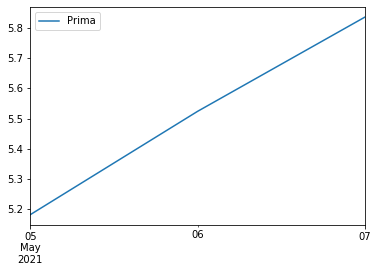

In [50]:
strike = K
call=pd.DataFrame({'Prima':np.exp(-r*ndays)*np.fmax(sim_closes - strike, 0).mean(axis=1)}, index=dates)
call.plot();

In [51]:
call.iloc[-1]

Prima    5.835541
Name: 2021-05-07 00:00:00, dtype: float64

### Intervarlos de confianza

In [52]:
confianza = 0.95
sigma_est = sim_closes.iloc[-1].sem()
mean_est = call.iloc[-1].Prima
# i1 = st.t.interval(confianza,nscen-1, loc=mean_est, scale=sigma_est)
i2 = st.norm.interval(confianza, loc=mean_est, scale=sigma_est)
print(i2)

(5.714381104075803, 5.956701529726632)


In [53]:
opt_valuar['JSON']

{'contractSymbol': 'MCD210507C00230000',
 'strike': 230.0,
 'currency': 'USD',
 'lastPrice': 4.58,
 'change': 0.11000013,
 'percentChange': 2.460853,
 'volume': 50,
 'openInterest': 445,
 'bid': 4.85,
 'ask': 5.6,
 'contractSize': 'REGULAR',
 'expiration': 1620345600,
 'lastTradeDate': 1620235011,
 'impliedVolatility': 0.2651440673828125,
 'inTheMoney': True}

### 1.2 Histograma de rendimientos

In [57]:
# Centro mis datos en mi tasa libre de riesgo
freq, values = np.histogram(ret_mc-mu+r, bins=10000)
# freq = freq.astype('float32')
prob = freq/np.sum(freq)


In [58]:
# Datos de la opción y del día de actual
today = pd.Timestamp(date.today())
expiry = opt_valuar.Expiry

# Fechas desde el día de hoy hasta la fecha de cierre del contrato (considerando unicamente los días hábiles)
dates = pd.date_range(start=today, end=expiry, freq='B')

# Cantidad de escenarios a simular para el método de montecarlo
ndays = len(dates)
nscen = 10000

K = opt_valuar.Strike
S0 = closes_mc.iloc[-1]

ret = np.random.choice(values[1:], (ndays,nscen), p=prob)
sim_ret_hist = pd.DataFrame(ret, index=dates)
sim_closes_hist = S0*np.exp(sim_ret_hist.cumsum())

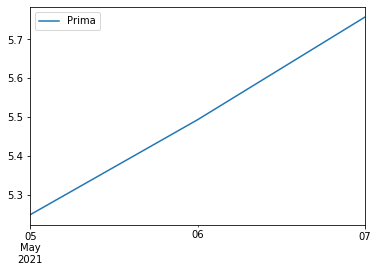

In [59]:
strike = pd.DataFrame(K*np.ones([ndays,nscen]),index=dates)
call_hist=pd.DataFrame({'Prima':np.exp(-r*ndays)*np.fmax(sim_closes_hist-strike,np.zeros([ndays,nscen])).T.mean()},index=dates)
call_hist.plot();

In [60]:
call_hist.iloc[-1]

Prima    5.757603
Name: 2021-05-07 00:00:00, dtype: float64

### INTERVALO DE CONFIANZA DEL 95%

In [61]:
confianza = 0.95
sigma_est = sim_closes_hist.iloc[-1].sem()
mean_est = call_hist.iloc[-1].Prima
# i1 = st.t.interval(confianza,nscen-1, loc=mean_est, scale=sigma_est)
i2 = st.norm.interval(confianza, loc=mean_est, scale=sigma_est)
print(i2)

(5.634705479118243, 5.880499746676507)


Notemos que el valor real de la opción que estamos valuando se encuentra muy cerca del intervalo de confianza, por lo tanto los resultado obtenidos son muy confiables.
El valor de la opción es:

In [62]:
opt_valuar['JSON']['lastPrice']

4.58

# 'CALL'- down-and-out

## VALUACIÓN DE UNA OPCION 'CALL'- down-and-out

### 3.1 Modelo normal de rendimientos

In [64]:
mu = ret_mc.mean()
sigma = ret_mc.std()
r = 0.006/360
mu, sigma, r

(0.0007154094263900964, 0.015203373533159606, 1.6666666666666667e-05)

In [65]:
# Datos de la opción y del día de actual
today = pd.Timestamp(date.today())
expiry = opt_valuar.Expiry

# Fechas desde el día de hoy hasta la fecha de cierre del contrato (considerando unicamente los días hábiles)
dates = pd.date_range(start = today, end = expiry, freq='B')

# Cantidad de escenarios a simular para el método de montecarlo
ndays = len(dates)
nscen = 10000

K = opt_valuar.Strike
S0 = closes_mc.iloc[-1]

sim_ret = pd.DataFrame(sigma*np.random.randn(ndays,nscen)+r,index=dates)
sim_closes = S0*np.exp(sim_ret.cumsum())
S0

235.0399932861328

In [66]:
opt_valuar.Underlying_Price

235.04

In [84]:
pd.set_option('display.max_columns', 35)

B= 230

# Función de desactivación (knock-out)
# Si en algún momento el precio toca la barrera la opción se desactiva
I = (sim_closes > B).cumprod(axis=0)> 0
I


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,...,9983,9984,9985,9986,9987,9988,9989,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
2021-05-05,True,True,True,True,True,False,True,True,True,False,True,True,True,True,True,True,True,...,True,True,True,True,True,False,True,True,True,True,True,False,True,True,True,True,True
2021-05-06,True,True,True,True,False,False,True,True,True,False,True,True,True,True,True,True,True,...,True,False,True,True,True,False,True,True,True,True,True,False,True,True,True,True,True
2021-05-07,True,True,True,True,False,False,True,True,True,False,True,True,True,True,True,True,True,...,True,False,True,True,True,False,True,True,True,True,True,False,True,True,True,True,False


In [85]:
K = opt_valuar.Strike
S0 = opt_valuar.Underlying_Price
K, S0

(230.0, 235.04)

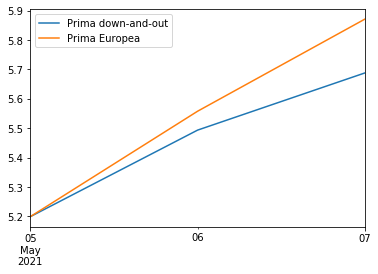

In [86]:
# Definir strike
strike = K
# Calcular la prima de una opción Europea
call = pd.DataFrame({'Prima Europea':np.exp(-r*ndays)*np.fmax(sim_closes - strike, 0)
                     .mean(axis=1)},index=dates)
# Calcular la prima de una opción barrera
callui = pd.DataFrame({'Prima down-and-out':np.exp(-r*ndays)*(I * np.fmax(sim_closes - strike, 0))
                       .mean(axis=1)},index=dates)
# Graficar el resultado de las dos primas previamente valuadas
ax = callui.plot();
call.plot(ax=ax);

In [87]:
call.iloc[-1]

Prima Europea    5.871478
Name: 2021-05-07 00:00:00, dtype: float64

In [88]:
callui.iloc[-1]

Prima down-and-out    5.688329
Name: 2021-05-07 00:00:00, dtype: float64

#  'PUT'- Up-and-out

## VALUACIÓN DE UNA OPCION 'PUT'- Up-and-out

In [147]:
opt_deseada = mc_opt.loc[(mc_opt.Type=='put') & (mc_opt.Strike==240) & (mc_opt.Expiry=='2021-05-07')]
opt_deseada

,Strike,Expiry,Type,Symbol,Last,Bid,Ask,Chg,PctChg,Vol,Open_Int,IV,Root,IsNonstandard,Underlying,Underlying_Price,Quote_Time,Last_Trade_Date,JSON
429,240.0,2021-05-07,put,MCD210507P00240000,8.0,4.6,6.35,1.75,28.0,1.0,23.0,0.383307,MCD,False,MCD,235.04,2021-05-05 20:00:02,2021-05-05 14:42:42,"{'contractSymbol': 'MCD210507P00240000', 'stri..."


In [148]:
opt_valuar = opt_deseada.loc[list(opt_deseada.index)[0]]
opt_valuar

Strike                                                            240
Expiry                                            2021-05-07 00:00:00
Type                                                              put
Symbol                                             MCD210507P00240000
Last                                                                8
                                          ...                        
Underlying                                                        MCD
Underlying_Price                                               235.04
Quote_Time                                        2021-05-05 20:00:02
Last_Trade_Date                                   2021-05-05 14:42:42
JSON                {'contractSymbol': 'MCD210507P00240000', 'stri...
Name: 429, Length: 19, dtype: object

# Simulación de precios

### 1.1 Modelo normal de rendimientos

In [149]:
mu = ret_mc.mean()
sigma = ret_mc.std()
r = (0.06/100) / 360
mu, sigma, r

(0.0007154094263900964, 0.015203373533159606, 1.6666666666666665e-06)

In [150]:
from datetime import date

# Datos de la opción y del día de actual
today = pd.Timestamp(date.today())
expiry = opt_valuar.Expiry

# Fechas desde el día de hoy hasta la fecha de cierre del contrato (considerando unicamente los días hábiles)
dates = pd.date_range(start=today, end=expiry, freq='B')

# Cantidad de escenarios a simular para el método de montecarlo
ndays = len(dates)
nscen = 10000

K = opt_valuar.Strike
S0 = closes_mc.iloc[-1]
sim_ret = pd.DataFrame(sigma*np.random.randn(ndays,nscen)+r,index=dates)
sim_closes = S0*np.exp(sim_ret.cumsum())

### Valuación de la opción baśandonos en la función de pago correspondiente (Europea)

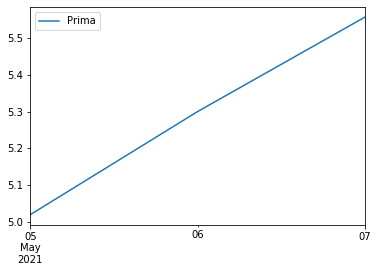

In [151]:
strike = K
put=pd.DataFrame({'Prima':np.exp(-r*ndays)*np.fmax(strike - sim_closes, 0).mean(axis=1)}, index=dates)
put.plot();

In [152]:
put.iloc[-1]

Prima    5.557368
Name: 2021-05-07 00:00:00, dtype: float64

### INTERVALO DE CONFIANZA DEL 95%

In [153]:
confianza = 0.95
sigma_est = sim_closes.iloc[-1].sem()
mean_est = put.iloc[-1].Prima
# i1 = st.t.interval(confianza,nscen-1, loc=mean_est, scale=sigma_est)
i2 = st.norm.interval(confianza, loc=mean_est, scale=sigma_est)
print(i2)

(5.43611620463181, 5.678620540401981)


Notemos que el valor real de la opción que estamos valuando se encuentra muy cerca del intervalo de confianza, por lo tanto los resultado obtenidos son muy confiables.
El valor de la opción es:

In [154]:
opt_valuar['JSON']['lastPrice']

8.0

### 1.2 Histograma de rendimientos

In [155]:
# Centro mis datos en mi tasa libre de riesgo
freq, values = np.histogram(ret_mc-mu+r, bins=10000)
# freq = freq.astype('float32')
prob = freq/np.sum(freq)



In [156]:
# Datos de la opción y del día de actual
today = pd.Timestamp(date.today())
expiry = opt_valuar.Expiry

# Fechas desde el día de hoy hasta la fecha de cierre del contrato (considerando unicamente los días hábiles)
dates = pd.date_range(start=today, end=expiry, freq='B')

# Cantidad de escenarios a simular para el método de montecarlo
ndays = len(dates)
nscen = 10000

K = opt_valuar.Strike
S0 = closes_mc.iloc[-1]

ret = np.random.choice(values[1:], (ndays,nscen), p=prob)
sim_ret_hist = pd.DataFrame(ret, index=dates)
sim_closes_hist = S0*np.exp(sim_ret_hist.cumsum())

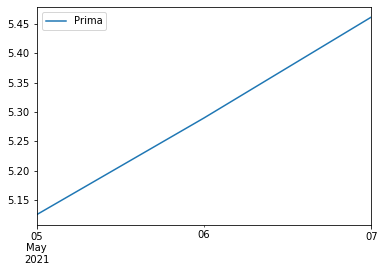

In [157]:
strike = pd.DataFrame(K*np.ones([ndays,nscen]),index=dates)
put_hist=pd.DataFrame({'Prima':np.exp(-r*ndays)*np.fmax(strike - sim_closes_hist,np.zeros([ndays,nscen])).T.mean()},index=dates)
put_hist.plot();

In [158]:
put_hist.iloc[-1]

Prima    5.461964
Name: 2021-05-07 00:00:00, dtype: float64

### INTERVALO DE CONFIANZA DEL 95%

In [159]:
confianza = 0.95
sigma_est = sim_closes_hist.iloc[-1].sem()
mean_est = put_hist.iloc[-1].Prima
# i1 = st.t.interval(confianza,nscen-1, loc=mean_est, scale=sigma_est)
i2 = st.norm.interval(confianza, loc=mean_est, scale=sigma_est)
print(i2)

(5.340990593340168, 5.5829379727935695)


In [160]:
opt_valuar['JSON']['lastPrice']

8.0

In [161]:
# Datos de la opción y del día de actual
today = pd.Timestamp(date.today())
expiry = opt_valuar.Expiry

# Fechas desde el día de hoy hasta la fecha de cierre del contrato (considerando unicamente los días hábiles)
dates = pd.date_range(start = today, end = expiry, freq='B')

# Cantidad de escenarios a simular para el método de montecarlo
ndays = len(dates)
nscen = 10000

K = opt_valuar.Strike
S0 = closes_mc.iloc[-1]

sim_ret = pd.DataFrame(sigma*np.random.randn(ndays,nscen)+r,index=dates)
sim_closes = S0*np.exp(sim_ret.cumsum())
S0

235.0399932861328

In [162]:
opt_valuar.Underlying_Price

235.04

In [163]:
pd.set_option('display.max_columns', 35)

B= 240

# Función de desactivación (knock-out)
# Si en algún momento el precio toca la barrera la opción se desactiva
I = (sim_closes < B).cumprod(axis=0) > 0
I

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,...,9983,9984,9985,9986,9987,9988,9989,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
2021-05-05,True,True,True,False,True,True,True,True,False,True,True,True,True,True,True,True,True,...,True,True,False,True,True,True,True,True,True,True,False,True,True,True,True,True,True
2021-05-06,True,True,True,False,True,True,True,True,False,True,True,True,True,True,True,True,True,...,False,True,False,True,True,True,True,True,True,True,False,False,True,False,True,True,True
2021-05-07,True,False,True,False,True,True,True,True,False,True,True,False,True,True,True,True,True,...,False,True,False,True,True,True,False,True,True,True,False,False,True,False,True,True,True


In [164]:
K = opt_valuar.Strike
S0 = opt_valuar.Underlying_Price
K, S0

(240.0, 235.04)

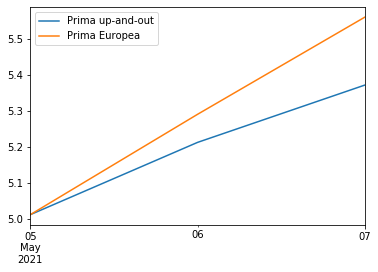

In [165]:
# Definir strike
strike = K
# Calcular la prima de una opción Europea
put = pd.DataFrame({'Prima Europea':np.exp(-r*ndays)*np.fmax(strike - sim_closes , 0)
                     .mean(axis=1)},index=dates)
# Calcular la prima de una opción barrera
putui = pd.DataFrame({'Prima up-and-out':np.exp(-r*ndays)*(I * np.fmax(strike-sim_closes, 0))
                       .mean(axis=1)},index=dates)
# Graficar el resultado de las dos primas previamente valuadas
ax = putui.plot();
put.plot(ax=ax);

In [166]:
put.iloc[-1]

Prima Europea    5.561215
Name: 2021-05-07 00:00:00, dtype: float64

In [167]:
putui.iloc[-1]

Prima up-and-out    5.372725
Name: 2021-05-07 00:00:00, dtype: float64

## ANALISIS FINAL

# RESPUESTA JUAN PABLO